# A comparison of algorithms for solving Kakurasu puzzles

In [4]:
! pip3 install ipyfilechooser matplotlib


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


## 1. Load a .txt file
The file must have the following format:
1. Row 1: dimension
2. Row 2: target sums for each row
3. Row 3: target sums for each column

**IMPORTANT**
**Run the next two cells in order to "Run All" notebook.**

In [5]:
from ipyfilechooser import FileChooser

# Create a file chooser starting at the current directory, filtering for .txt files
fc = FileChooser(path=".", filter_pattern="*.txt", title="Select a Kakurasu puzzle file")
display(fc)

FileChooser(path='/Users/walteramador/Documents/LU/COSC-4117EL-01-Artificial-Intelligence/Assignment_1', filen…

In [6]:
print("Selected file:", fc.selected)
# print the selected file content
if fc.selected:
    with open(fc.selected, 'r') as file:
        content = file.read()
        print(content)
else:
    print("No file selected.")

Selected file: None
No file selected.


In [7]:
# Validate the file content format
def validate_file_format(content):
    rows = content.strip().split('\n')
    if len(rows) < 3:
        print("Invalid file format: Not enough rows.")
        return False
    dimensions = rows[0]
    if not dimensions.isdigit():
        print("Invalid file format: First line must be an integer for dimensions.")
        return False

    dimensions = int(dimensions)
    rows_target_sum = rows[1].split(',')
    cols_target_sum = rows[2].split(',')

    if len(rows_target_sum) != dimensions or len(cols_target_sum) != dimensions or len(rows_target_sum) != len(cols_target_sum):
        print("Invalid file format: Target sums do not match dimensions.")
        return False
    for sum_str in rows_target_sum:
        if not sum_str.isdigit():
            print("Invalid file format: Row target sums must be integers.")
            return False
    for sum_str in cols_target_sum:
        if not sum_str.isdigit():
            print("Invalid file format: Column target sums must be integers.")
            return False
    print("File format is valid.")
    return True

is_valid_file = validate_file_format(content)


NameError: name 'content' is not defined

In [ ]:
if not is_valid_file:
    raise ValueError("Invalid Kakurasu puzzle file format.")

# Get file values
rows = content.strip().split('\n')
rows_target_sum = rows[1].split(',')
cols_target_sum = rows[2].split(',')
for i in range(len(rows_target_sum)):
    rows_target_sum[i] = int(rows_target_sum[i])
    cols_target_sum[i] = int(cols_target_sum[i])

## 2. Display the puzzle

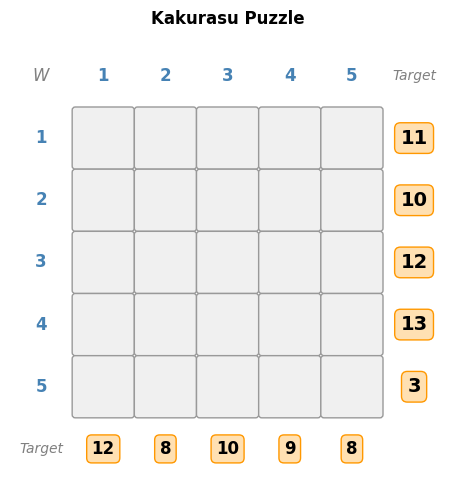

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def display_kakurasu(rows_target_sum, cols_target_sum, solution=None):
    """Display a Kakurasu puzzle grid with weights and target sums.
    If solution is None, shows the unsolved (empty) puzzle.
    solution should be a 2D list/array of 0s and 1s if provided.
    """
    n = len(rows_target_sum)
    col_weights = list(range(1, n + 1))
    row_weights = list(range(1, n + 1))

    fig, ax = plt.subplots(figsize=(n, n))

    # Draw column weights on top
    for j in range(n):
        ax.text(j + 1.5, n + 0.5, str(col_weights[j]),
                ha='center', va='center', fontsize=12, fontweight='bold', color='steelblue')

    # Draw row weights on the left
    for i in range(n):
        ax.text(0.5, n - i - 0.5, str(row_weights[i]),
                ha='center', va='center', fontsize=12, fontweight='bold', color='steelblue')

    # Draw the grid cells
    for i in range(n):
        for j in range(n):
            filled = False
            if solution is not None and solution[i][j] == 1:
                filled = True
            color = '#4CAF50' if filled else '#f0f0f0'
            textcolor = 'white' if filled else '#cccccc'
            rect = patches.FancyBboxPatch((j + 1.05, n - i - 0.95), 0.9, 0.9,
                                          boxstyle="round,pad=0.05",
                                          facecolor=color, edgecolor='#999999', linewidth=1)
            ax.add_patch(rect)
            if filled:
                ax.text(j + 1.5, n - i - 0.5, '●',
                        ha='center', va='center', fontsize=12, color=textcolor)

    # Draw row target sums on the right
    for i in range(n):
        ax.text(n + 1.5, n - i - 0.5, str(rows_target_sum[i]),
                ha='center', va='center', fontsize=14, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFE0B2', edgecolor='#FF9800'))

    # Draw column target sums on the bottom
    for j in range(n):
        ax.text(j + 1.5, -0.5, str(cols_target_sum[j]),
                ha='center', va='center', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFE0B2', edgecolor='#FF9800'))

    # Labels
    ax.text(0.5, n + 0.5, 'W', ha='center', va='center', fontsize=12, fontstyle='italic', color='gray')
    ax.text(n + 1.5, n + 0.5, 'Target', ha='center', va='center', fontsize=10, fontstyle='italic', color='gray')
    ax.text(0.5, -0.5, 'Target', ha='center', va='center', fontsize=10, fontstyle='italic', color='gray')

    ax.set_xlim(0, n + 2)
    ax.set_ylim(-1, n + 1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Kakurasu Puzzle', fontsize=12, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()

# Display the unsolved puzzle
display_kakurasu(rows_target_sum, cols_target_sum)

## 3. Backtracking search

In [ ]:
import time

def backtracking_search(rows_target_sum, cols_target_sum, timeout=60, heuristic=None, fixed_cells=None):
    """
    Solve a Kakurasu puzzle using backtracking search.

    Parameters:
        rows_target_sum: list of target sums for each row
        cols_target_sum: list of target sums for each column
        timeout: maximum time in seconds before giving up (default 60)
        heuristic: None for pure backtracking, or "MRV", "MCV", "LCV"
            - MRV (Minimum Remaining Values): pick the cell with fewest feasible values
            - MCV (Most Constraining Variable): pick the cell with most unassigned neighbors
            - LCV (Least Constraining Value): try the value that leaves most options for neighbors
        fixed_cells: optional dict of {(i, j): value} for pre-determined cells (e.g. from AC-3)

    Returns:
        solution: nxn matrix of 0s and 1s (or None if no solution / timeout)
        elapsed_time: time taken in seconds
        nodes_visited: number of nodes explored during search
    """
    if heuristic not in (None, "MRV", "MCV", "LCV"):
        raise ValueError(f"Invalid heuristic: {heuristic}. Use None, 'MRV', 'MCV', or 'LCV'.")

    n = len(rows_target_sum)
    grid = [[-1] * n for _ in range(n)]  # -1 = unassigned
    unassigned = set((i, j) for i in range(n) for j in range(n))

    # Apply fixed cells (pre-determined by AC-3 or other preprocessing)
    if fixed_cells:
        for (i, j), val in fixed_cells.items():
            grid[i][j] = val
            unassigned.discard((i, j))

    nodes_visited = 0
    start_time = time.time()
    timed_out = False

    def is_consistent(row, col, val):
        """Check if assigning val to (row, col) is consistent with constraints."""
        old = grid[row][col]
        grid[row][col] = val

        ok = True

        # --- Row check ---
        row_sum = 0
        row_remaining = 0
        row_complete = True
        for j in range(n):
            if grid[row][j] != -1:
                row_sum += grid[row][j] * (j + 1)
            else:
                row_remaining += (j + 1)
                row_complete = False

        if row_sum > rows_target_sum[row] or row_sum + row_remaining < rows_target_sum[row]:
            ok = False
        elif row_complete and row_sum != rows_target_sum[row]:
            ok = False

        # --- Column check ---
        if ok:
            col_sum = 0
            col_remaining = 0
            col_complete = True
            for i in range(n):
                if grid[i][col] != -1:
                    col_sum += grid[i][col] * (i + 1)
                else:
                    col_remaining += (i + 1)
                    col_complete = False

            if col_sum > cols_target_sum[col] or col_sum + col_remaining < cols_target_sum[col]:
                ok = False
            elif col_complete and col_sum != cols_target_sum[col]:
                ok = False

        grid[row][col] = old
        return ok

    def get_feasible_values(row, col):
        """Return list of feasible values (0 or 1) for an unassigned cell."""
        return [v for v in [0, 1] if is_consistent(row, col, v)]

    def select_variable():
        """Select the next unassigned variable based on heuristic."""
        if heuristic == "MRV":
            # Minimum Remaining Values: pick cell with fewest legal values
            return min(unassigned, key=lambda cell: len(get_feasible_values(cell[0], cell[1])))
        elif heuristic == "MCV":
            # Most Constraining Variable (degree heuristic):
            # pick cell sharing constraints with most unassigned neighbors
            return max(unassigned, key=lambda cell: (
                sum(1 for j in range(n) if j != cell[1] and (cell[0], j) in unassigned) +
                sum(1 for i in range(n) if i != cell[0] and (i, cell[1]) in unassigned)
            ))
        else:
            # Fixed row-major order (pure backtracking or LCV)
            return min(unassigned)

    def order_values(row, col):
        """Order domain values based on heuristic."""
        if heuristic == "LCV":
            # Least Constraining Value: try value that leaves most options for neighbors
            feasible = get_feasible_values(row, col)
            if len(feasible) <= 1:
                return feasible

            def neighbor_options(val):
                grid[row][col] = val
                total = 0
                # Count feasible values for all unassigned neighbors in same row
                for j in range(n):
                    if j != col and (row, j) in unassigned:
                        total += sum(1 for v in [0, 1] if is_consistent(row, j, v))
                # Count feasible values for all unassigned neighbors in same column
                for i in range(n):
                    if i != row and (i, col) in unassigned:
                        total += sum(1 for v in [0, 1] if is_consistent(i, col, v))
                grid[row][col] = -1
                return total

            # Sort descending by neighbor options (most options first = least constraining)
            return sorted(feasible, key=lambda v: -neighbor_options(v))
        else:
            # Default order: try 0 then 1
            return [0, 1]

    def solve():
        nonlocal nodes_visited, timed_out

        if time.time() - start_time > timeout:
            timed_out = True
            return False

        if not unassigned:
            return True  # All cells assigned consistently

        row, col = select_variable()
        nodes_visited += 1

        for value in order_values(row, col):
            if is_consistent(row, col, value):
                grid[row][col] = value
                unassigned.discard((row, col))

                if solve():
                    return True

                if timed_out:
                    return False

                # Backtrack
                grid[row][col] = -1
                unassigned.add((row, col))

        return False

    found = solve()
    elapsed_time = time.time() - start_time
    label = heuristic or "pure"

    if timed_out:
        print(f"Backtracking ({label}) timed out after {timeout}s. Nodes visited: {nodes_visited}")
        return None, elapsed_time, nodes_visited
    elif not found:
        print(f"No solution found ({label}). Nodes visited: {nodes_visited}")
        return None, elapsed_time, nodes_visited
    else:
        solution = [[max(0, grid[i][j]) for j in range(n)] for i in range(n)]
        print(f"Solution found ({label}) in {elapsed_time:.8f}s. Nodes visited: {nodes_visited}")
        return solution, elapsed_time, nodes_visited


Running pure backtracking search...
Solution found (pure) in 0.00044179s. Nodes visited: 162

Time: 0.00044179s | Nodes visited: 162


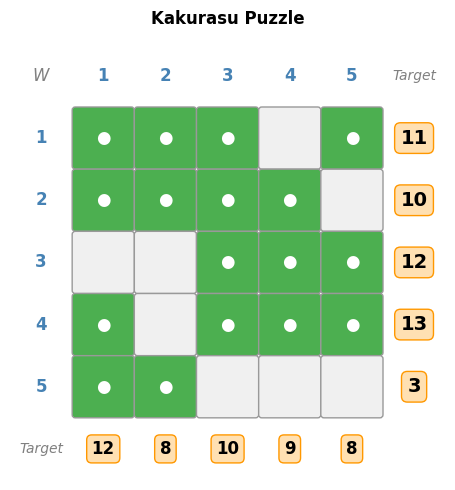


Running backtracking search with MRV heuristic...
Solution found (MRV) in 0.00063205s. Nodes visited: 25

Time: 0.00063205s | Nodes visited: 25

Running backtracking search with MCV heuristic...
Solution found (MCV) in 0.00136614s. Nodes visited: 88

Time: 0.00136614s | Nodes visited: 88

Running backtracking search with LCV heuristic...
Solution found (LCV) in 0.00038195s. Nodes visited: 40

Time: 0.00038195s | Nodes visited: 40


In [ ]:
# Run pure backtracking (no heuristic)
print("\nRunning pure backtracking search...")
bt_solution, bt_time, bt_nodes = backtracking_search(rows_target_sum, cols_target_sum, timeout=60)

if bt_solution is not None:
    print(f"\nTime: {bt_time:.8f}s | Nodes visited: {bt_nodes}")
    display_kakurasu(rows_target_sum, cols_target_sum, solution=bt_solution)

# Run with MRV heuristic
print("\nRunning backtracking search with MRV heuristic...")
mrv_solution, mrv_time, mrv_nodes = backtracking_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="MRV")

if mrv_solution is not None:
    print(f"\nTime: {mrv_time:.8f}s | Nodes visited: {mrv_nodes}")
    # display_kakurasu(rows_target_sum, cols_target_sum, solution=mrv_solution)

# Run with MCV heuristic
print("\nRunning backtracking search with MCV heuristic...")
mcv_solution, mcv_time, mcv_nodes = backtracking_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="MCV")

if mcv_solution is not None:
    print(f"\nTime: {mcv_time:.8f}s | Nodes visited: {mcv_nodes}")
    # display_kakurasu(rows_target_sum, cols_target_sum, solution=mcv_solution)

# Run with LCV heuristic
print("\nRunning backtracking search with LCV heuristic...")
lcv_solution, lcv_time, lcv_nodes = backtracking_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="LCV")

if lcv_solution is not None:
    print(f"\nTime: {lcv_time:.8f}s | Nodes visited: {lcv_nodes}")
    # display_kakurasu(rows_target_sum, cols_target_sum, solution=lcv_solution)

## 4. AC-3 Algorithm

In [ ]:
import time
from collections import deque

def ac3_search(rows_target_sum, cols_target_sum, timeout=60, heuristic=None):
    """
    Solve a Kakurasu puzzle using AC-3 (Arc Consistency 3) for domain pruning,
    then falling back to backtracking_search for any remaining unresolved cells.

    Parameters:
        rows_target_sum: list of target sums for each row
        cols_target_sum: list of target sums for each column
        timeout: maximum time in seconds before giving up (default 60)
        heuristic: heuristic to pass to backtracking_search fallback
                   (None, "MRV", "MCV", or "LCV")

    Returns:
        solution: nxn matrix of 0s and 1s (or None if no solution / timeout)
        elapsed_time: time taken in seconds
        nodes_visited: number of nodes explored during search
    """
    n = len(rows_target_sum)
    start_time = time.time()

    # --- Build CSP domains ---
    domains = {(i, j): {0, 1} for i in range(n) for j in range(n)}

    def get_row_peers(i):
        return [(i, j) for j in range(n)]

    def get_col_peers(j):
        return [(i, j) for i in range(n)]

    def get_arcs():
        arcs = deque()
        for i in range(n):
            for j in range(n):
                if len(domains[(i, j)]) > 0:
                    arcs.append(((i, j), ('row', i)))
                    arcs.append(((i, j), ('col', j)))
        return arcs

    def revise(var, constraint_id):
        """Remove values from var's domain that can't satisfy the constraint."""
        revised = False
        ctype, idx = constraint_id

        if ctype == 'row':
            cells = get_row_peers(idx)
            target = rows_target_sum[idx]
            weight_fn = lambda cell: cell[1] + 1
        else:
            cells = get_col_peers(idx)
            target = cols_target_sum[idx]
            weight_fn = lambda cell: cell[0] + 1

        other_cells = [c for c in cells if c != var]

        to_remove = set()
        for val in domains[var]:
            my_contribution = val * weight_fn(var)

            other_min = 0
            other_max = 0
            for c in other_cells:
                contributions = [v * weight_fn(c) for v in domains[c]]
                if not contributions:
                    to_remove.add(val)
                    break
                other_min += min(contributions)
                other_max += max(contributions)
            else:
                if target < my_contribution + other_min or target > my_contribution + other_max:
                    to_remove.add(val)

        for val in to_remove:
            domains[var].discard(val)
            revised = True

        return revised

    def ac3():
        """Run AC-3. Returns True if consistent, False if a domain is emptied."""
        queue = get_arcs()

        while queue:
            if time.time() - start_time > timeout:
                return False

            var, constraint_id = queue.popleft()

            if revise(var, constraint_id):
                if len(domains[var]) == 0:
                    return False

                row_i, col_j = var
                if constraint_id != ('row', row_i):
                    for c in get_row_peers(row_i):
                        if c != var:
                            queue.append((c, ('row', row_i)))
                if constraint_id != ('col', col_j):
                    for c in get_col_peers(col_j):
                        if c != var:
                            queue.append((c, ('col', col_j)))

        return True

    # --- Run AC-3 ---
    consistent = ac3()
    ac3_elapsed = time.time() - start_time

    if not consistent:
        print(f"AC-3 found inconsistency in {ac3_elapsed:.8f}s.")
        return None, ac3_elapsed, 0

    # Extract fixed cells (domains reduced to a single value)
    fixed_cells = {}
    all_solved = True
    for (i, j), vals in domains.items():
        if len(vals) == 1:
            fixed_cells[(i, j)] = next(iter(vals))
        else:
            all_solved = False

    # If AC-3 solved everything, verify and return
    if all_solved:
        solution = [[fixed_cells[(i, j)] for j in range(n)] for i in range(n)]
        # Verify sums
        valid = True
        for i in range(n):
            if sum(solution[i][j] * (j + 1) for j in range(n)) != rows_target_sum[i]:
                valid = False
                break
        if valid:
            for j in range(n):
                if sum(solution[i][j] * (i + 1) for i in range(n)) != cols_target_sum[j]:
                    valid = False
                    break
        if valid:
            print(f"AC-3 solved the puzzle in {ac3_elapsed:.8f}s (no backtracking needed). "
                  f"Fixed {len(fixed_cells)}/{n*n} cells.")
            return solution, ac3_elapsed, 0

    # Fall back to backtracking_search with AC-3 pruned cells and chosen heuristic
    remaining_timeout = max(0, timeout - ac3_elapsed)
    fixed_count = len(fixed_cells)
    label = heuristic or "pure"
    print(f"AC-3 fixed {fixed_count}/{n*n} cells in {ac3_elapsed:.8f}s. "
          f"Falling back to backtracking ({label}) for remaining cells...")

    solution, bt_time, bt_nodes = backtracking_search(
        rows_target_sum, cols_target_sum,
        timeout=remaining_timeout,
        heuristic=heuristic,
        fixed_cells=fixed_cells
    )

    total_time = time.time() - start_time
    return solution, total_time, bt_nodes


Running AC-3 with pure backtracking fallback...
AC-3 solved the puzzle in 0.00050306s (no backtracking needed). Fixed 25/25 cells.

Total time: 0.00050306s | Backtracking nodes: 0


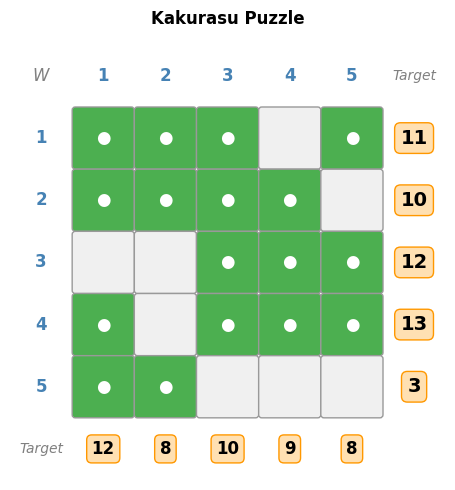


Running AC-3 with MRV backtracking fallback...
AC-3 solved the puzzle in 0.00055313s (no backtracking needed). Fixed 25/25 cells.

Total time: 0.00055313s | Backtracking nodes: 0

Running AC-3 with MCV backtracking fallback...
AC-3 solved the puzzle in 0.00047469s (no backtracking needed). Fixed 25/25 cells.

Total time: 0.00047469s | Backtracking nodes: 0

Running AC-3 with LCV backtracking fallback...
AC-3 solved the puzzle in 0.00046992s (no backtracking needed). Fixed 25/25 cells.

Total time: 0.00046992s | Backtracking nodes: 0


In [ ]:
# Run AC-3 (with pure backtracking fallback)
print("\nRunning AC-3 with pure backtracking fallback...")
ac3_solution, ac3_time, ac3_nodes = ac3_search(rows_target_sum, cols_target_sum, timeout=60)

if ac3_solution is not None:
    print(f"\nTotal time: {ac3_time:.8f}s | Backtracking nodes: {ac3_nodes}")
    display_kakurasu(rows_target_sum, cols_target_sum, solution=ac3_solution)

# Run AC-3 with MRV backtracking fallback
print("\nRunning AC-3 with MRV backtracking fallback...")
ac3_mrv_solution, ac3_mrv_time, ac3_mrv_nodes = ac3_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="MRV")

if ac3_mrv_solution is not None:
    print(f"\nTotal time: {ac3_mrv_time:.8f}s | Backtracking nodes: {ac3_mrv_nodes}")

# Run AC-3 with MCV backtracking fallback
print("\nRunning AC-3 with MCV backtracking fallback...")
ac3_mcv_solution, ac3_mcv_time, ac3_mcv_nodes = ac3_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="MCV")
if ac3_mcv_solution is not None:
    print(f"\nTotal time: {ac3_mcv_time:.8f}s | Backtracking nodes: {ac3_mcv_nodes}")

# Run AC-3 with LCV backtracking fallback
print("\nRunning AC-3 with LCV backtracking fallback...")
ac3_lcv_solution, ac3_lcv_time, ac3_lcv_nodes = ac3_search(rows_target_sum, cols_target_sum, timeout=60, heuristic="LCV")
if ac3_lcv_solution is not None:
    print(f"\nTotal time: {ac3_lcv_time:.8f}s | Backtracking nodes: {ac3_lcv_nodes}")


## Sources:

- https://github.com/walter-amador/csp_kakurasu_solver/blob/main/claude_opus_4_6.json
- https://chatgpt.com/share/69a37abd-e354-8010-9eee-cb9a071228a5